In [25]:
audio_path = "audio-data/drumloop.mp3"
name = "drumloop-ae"

# segmentation
block_length = 1 # number of frames in a stream block
BPM = 120
beat = 1 / 8 # metered divisions
hop_beats = 1 / 8 # hop length in beats
## alternatively, you can specify frame length and hop length in seconds
# frame_length_s = 0.1
# hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# clustering
# model architecture and training
step = 2 # step size for sliding window
hidden_units = 24 # number of hidden units in GRU layer
epochs = 100
batch_size = 32
validation_split = 0.2
patience = 15 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [26]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import librosa.display
# import IPython.display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy

if BPM is None and beat is not None or BPM is not None and beat is None:
    print("Please specify both BPM and beat if you are using metered divisions.")
    exit()
frame_length_s = (4 * beat * 60 / BPM) if BPM is not None else args.frame_length_s
hop_length_s = (4 * hop_beats * 60 / BPM) if BPM is not None else args.hop_length_s
sr = librosa.get_samplerate(audio_path)
frame_length = math.ceil(frame_length_s * sr) if frame_length_s is not None else args.frame_length
hop_length = math.ceil(hop_length_s * sr) if hop_length_s is not None else args.hop_length
stream = Streamer(audio_path, block_length, frame_length, hop_length)


In [27]:
# Spectral Centroid 	The center of gravity of the spectrum.
# 5 	Spectral Spread 	The second central moment of the spectrum.
# 6 	Spectral Entropy 	Entropy of the normalized spectral energies for a set of sub-frames.
# 7 	Spectral Flux 	The squared difference between the normalized magnitudes of the spectra of the two successive frames.
# 8 	Spectral Rolloff 	The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.

In [28]:

# helper function to extract features from audio block
def extract_features(y, sr):
    zcr = [librosa.zero_crossings(y).sum()]
    energy = [scipy.linalg.norm(y)]
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    m_centroid = np.median(spectral_centroid, axis=1)
    m_bandwith = np.median(spectral_bandwith, axis=1)
    m_flatness = np.median(spectral_flatness, axis=1)
    m_rolloff = np.median(spectral_rolloff, axis=1)
    if y.size >= 2048:  
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
    
    m_mfccs = np.median(mfccs, axis=1)
    if m_mfccs.size == 0:
        print("Empty frame!")
        return None
    else:        
        features = np.concatenate((zcr, energy, m_centroid, m_bandwith, m_flatness, m_rolloff, m_mfccs))
        return features

Audio length: 128.016s, 6144768 samples
Sample rate: 48000 Hz
Frame length: 0.25s,  12000 samples
Hop length: 0.25s, 12000 samples
Block length: 1 frame(s)
Number of blocks: 513
(513, 19)
(513, 19)
[-0.33685137 -0.41398088  0.23415425  0.23415425 -0.419142    0.11576887
 -4.2425808  -0.40418529 -0.43415831 -0.40965724 -0.42710094 -0.40814716
 -0.41349551 -0.40640078 -0.41207224 -0.4074899  -0.41267933 -0.40764511
 -0.41455116]
[ 0.89446114  0.23426025  1.51580417  3.49427288  0.23811116  3.54006506
 -0.55510719  0.23994505  0.23415425  0.23415425  0.23415425  0.23415425
  0.23415425  0.23415425  0.23415425  0.23415425  0.23415425  0.23415425
  0.23415425]
[ 0.89446114 -0.23703537  0.29853695  3.31132959 -0.27830617  0.11576887
 -2.57420888  0.17051861  0.03896163 -0.02986914 -0.10245753 -0.1484586
 -0.16675341 -0.18349676 -0.20101659 -0.21369144 -0.22534009 -0.23204122
 -0.23690159]


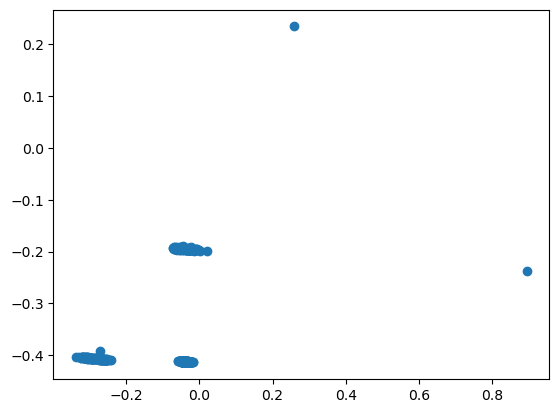

In [29]:


print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr) for block in stream.new()])
features_scaled = preprocessing.scale(features, axis=1)
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    # plt.xlabel('MFCC0 (scaled)')
    # plt.ylabel('MFCC1 Centroid (scaled)')   
    plt.show()

In [30]:
x = features_scaled[:10]
x.shape

(10, 19)

In [35]:
seq_in.shape

(1, 10, 19)

In [36]:
seq_out.shape

(1, 9, 19)

In [42]:
# lstm autoencoder reconstruct and predict sequence
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras import Sequential
# define input sequence
seq_in = x
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 19))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1
seq_in = seq_in[:, :-1, :]
n_in = len(seq_in)
# define encoder
visible = Input(shape=(9,19))
encoder = LSTM(100, activation='relu')(visible)
# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(19))(decoder2)
# tie it together
model = Model(inputs=visible, outputs=decoder2)
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=100, verbose=1)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=1)
print(yhat)


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.0294
Epoch 2/100
1/1 [==============================] - 0s 189ms/step - loss: 0.9927
Epoch 3/100
1/1 [==============================] - 0s 184ms/step - loss: 0.9579
Epoch 4/100
1/1 [==============================] - 0s 189ms/step - loss: 0.9232
Epoch 5/100
1/1 [==============================] - 0s 197ms/step - loss: 0.8870
Epoch 6/100
1/1 [==============================] - 0s 230ms/step - loss: 0.8468
Epoch 7/100
1/1 [==============================] - 0s 250ms/step - loss: 0.8011
Epoch 8/100
1/1 [==============================] - 0s 203ms/step - loss: 0.7468
Epoch 9/100
1/1 [==============================] - 0s 190ms/step - loss: 0.6812
Epoch 10/100
1/1 [==============================] - 0s 205ms/step - loss: 0.6046
Epoch 11/100
1/1 [==============================] - 0s 185ms/step - loss: 0.5266
Epoch 12/100
1/1 [==============================] - 0s 220ms/step - loss: 0.5015
Epoch 13/100
1/1 [======================

In [44]:
print(yhat)

[[[ 1.2864344  -0.19758976  0.22784278  4.021671   -0.62029165
    0.22261855 -3.1923573   0.17660795  0.05810229 -0.00652567
   -0.02704872 -0.01213004 -0.11660396 -0.15580559  0.044831
   -0.12303618 -0.26355705 -0.3252981  -0.36174312]
  [-0.48533517 -0.35593224  1.300436    0.95810676  0.01300508
    3.085816   -0.01180083 -0.50787103 -0.5038781  -0.4469477
   -0.6765906  -0.4475043  -0.48508143 -0.3118635  -0.7470325
   -0.29166284 -0.23528242  0.08919138 -0.22974817]
  [ 0.17197698 -0.26656854  0.9199462   3.2969942  -0.7410288
    1.8599207  -1.6911094  -0.06463636 -0.21259095 -0.22706072
   -0.17017417 -0.4242166  -0.25278696 -0.38727343 -0.10231247
   -0.48417643 -0.44714606 -0.48343396 -0.58676714]
  [-0.4171507  -0.39057785  1.2226102   1.5155826  -0.13697837
    2.9368749  -0.41541556 -0.40839502 -0.40781882 -0.39252728
   -0.55325544 -0.38186565 -0.44983992 -0.40843907 -0.62629837
   -0.39517042 -0.29967672 -0.1549793  -0.32872847]
  [-0.01611521 -0.28953758  0.9921107   2

In [45]:
yhatt = model.predict(yhat, verbose=1)
print(yhatt)

1/1 [==============================] - 0s 39ms/step
[[[ 1.24492097e+00 -1.93660438e-01  1.89816862e-01  3.86651587e+00
   -6.05880857e-01  1.97132230e-01 -3.08562279e+00  1.52336821e-01
    5.46795726e-02 -1.86903998e-02 -1.75186098e-02 -2.13626847e-02
   -1.04307972e-01 -1.48671895e-01  5.47285490e-02 -1.13346487e-01
   -2.69753098e-01 -3.18238407e-01 -3.58684540e-01]
  [-4.36989546e-01 -3.55386615e-01  1.21508408e+00  9.43212867e-01
    4.70128655e-03  2.95083427e+00 -4.98030521e-02 -5.17266810e-01
   -4.97163981e-01 -4.36979175e-01 -6.48633897e-01 -4.35995072e-01
   -4.58835334e-01 -3.04522574e-01 -6.76018834e-01 -2.72567838e-01
   -2.28564978e-01  9.13128257e-02 -2.31914863e-01]
  [ 1.79468140e-01 -2.70995080e-01  8.49405289e-01  3.12790775e+00
   -7.16266274e-01  1.82897365e+00 -1.63462424e+00 -1.08364776e-01
   -2.18353435e-01 -2.55858094e-01 -1.79560259e-01 -4.25493211e-01
   -2.56773084e-01 -3.94987047e-01 -7.50278160e-02 -4.74460959e-01
   -4.33861434e-01 -4.61391687e-01 -5.72

In [18]:
seq_in

array([[[0.1],
        [0.2]],

       [[0.3],
        [0.4]],

       [[0.5],
        [0.6]],

       [[0.7],
        [0.8]],

       [[0.9],
        [0.2]],

       [[0.3],
        [0.4]],

       [[0.5],
        [0.6]],

       [[0.7],
        [0.8]],

       [[0.9],
        [1. ]]])

In [7]:
seq_out

array([[[0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]])

In [23]:
# lstm autoencoder reconstruct and predict sequence
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras import Sequential
# define input sequence
seq_in = np.array([[0.1, 0.2], [0.3, 0.4]])
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 2))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,2)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='predict_lstm_autoencoder.png')
# fit model
model.fit(seq_in, seq_out, epochs=30, verbose=1)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=1)
print(yhat[0,:,0])

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.1258
Epoch 2/30
1/1 [==============================] - 0s 31ms/step - loss: 0.1237
Epoch 3/30
1/1 [==============================] - 0s 32ms/step - loss: 0.1218
Epoch 4/30
1/1 [==============================] - 0s 31ms/step - loss: 0.1201
Epoch 5/30
1/1 [==============================] - 0s 30ms/step - loss: 0.1184
Epoch 6/30
1/1 [==============================] - 0s 31ms/step - loss: 0.1169
Epoch 7/30
1/1 [==============================] - 0s 28ms/step - loss: 0.1153
Epoch 8/30
1/1 [==============================] - 0s 33ms/step - loss: 0.1138
Epoch 9/30
1/1 [==============================] - 0s 31ms/step - loss: 0.1122
Epoch 10/30
1/1 [==============================] - 0s 34ms/step - loss: 0.1105
Epoch 11/30
1/1 [==============================] - 0s 36ms/step - loss: 0.1089
Epoch 12/30
1/1 [==============================] - 0s 34ms/step - loss: 0.1072
Epoch 13/30
1/1 [==============================] - 0s 32ms/step

In [107]:
frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    label = int(label)
    # print(label.dtype)
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

282
160512 170240


In [108]:
# One-hot encode
# build a subsequence for every <step> frames
# and a corresponding label that follows it
features = [] # these will be features
targets = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    features.append(labels[i: i + maxlen])
    targets.append(labels[i + maxlen])
from keras.utils import to_categorical
encoded_features = to_categorical(features, dtype ="bool")
encoded_targets = to_categorical(targets, dtype ="bool")

In [109]:

# one-hot encode features and targets
# adapted from wandb character generation code referenced at the beginning of this notebook
# encoded_features = np.zeros((len(features), maxlen, n_classes), dtype=bool)
# encoded_targets = np.zeros((len(targets), n_classes), dtype=bool)
# for i, sequence in enumerate(features):
#     # print(i, sequence)
#     for t, label in enumerate(sequence):
#         encoded_features[i, t, label] = 1
#         # print(encoded_features[i, t])
#     encoded_targets[i, targets[i]] = 1
# sanity check
if verbose:
    print(encoded_features.shape)
    print(encoded_targets.shape)

inputs = Input(shape=(maxlen, n_classes))
x = GRU(hidden_units, return_sequences=True)(inputs)
# according to DLWP [13.2.1] softmax tends to be unstable in float16
outputs = Dense(n_classes, activation='softmax', dtype="float32")(x)
callback = EarlyStopping(monitor='val_loss', patience=patience)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
model.compile(
    loss='sparse_categorical_crossentropy', # since we are using integer labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()

history = model.fit(
    encoded_features,
    encoded_targets,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,
    callbacks=[callback]
)

path = Path(directory + "/models/" + name)
print(f"Saving model to: {path}")
path.mkdir(exist_ok=True, parents=True)
model_path = path / (name + ".keras")
model.save(model_path)
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["beat"] = beat
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")
print(f"Total epochs : {len(history.history['loss'])}")
print(history.history['val_loss'][-1])

(879, 78, 78)
(879, 78)
Model: "trebles-8th"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 78, 78)]          0         
                                                                 
 gru_6 (GRU)                 (None, 78, 24)            7488      
                                                                 
 dense_6 (Dense)             (None, 78, 78)            1950      
                                                                 
Total params: 9,438
Trainable params: 9,438
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 2s 38ms/step - loss: 4.2769 - accuracy: 0.3349 - val_loss: 4.1757 - val_accuracy: 0.8195
Epoch 2/100
22/22 [==============================] - 0s 18ms/step - loss: 4.0282 - accuracy: 0.9541 - val_loss: 3.8608 - val_accuracy: 0.9872
Epoch 3/1